# Imports

In [96]:
import math
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

from boruta import BorutaPy

from IPython.core.display  import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

## Helper Functions

In [97]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\NA101776\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [98]:
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    mae_list =[]
    mape_list = []
    rmse_list = []
    for k in reversed( range(1, 6) ):
        if verbose:
            print('KFold Number: {}'.format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime. timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime. timedelta( days=(k-1)*6*7)

        #filtering dateset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #training and validation dateset

        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit( xtraining, ytraining)

        #prediction
        yhat = m.predict( xvalidation )

        #perfomance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))        

        #store perfomance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE CV': np.round( np.mean( mae_list ), 2).astype(str) + ' +/- ' + np.round( np.std( mae_list ), 2).astype(str), 
                        'MAPE CV': np.round( np.mean( mape_list ), 2).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2).astype(str),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype(str)}, index=[0])
        
        

In [99]:
def mean_absolut_percentage_error( y, yhat):
    return np.mean( np.abs( (y - yhat) / y))

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolut_percentage_error( y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

## Loading Data

In [100]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# Descricao dos dados

In [101]:
df1 = df_raw.copy()

In [102]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [103]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

In [104]:
df1.columns = cols_new

In [105]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [106]:
df1.shape

(1017209, 18)

## Data Types

In [107]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [108]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [109]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

#competition_open_since_month (mes e ano que abriu a loja competidora)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week (ano e a semana que a loja entrou nessa segunda promoção)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval (meses em que a promoção 2 ficou ativa)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [110]:
df1.sample(10)

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval month_map  is_promo
18936     1097            3 2015-07-15  11187       2779     1      1             0               0          b          b                 720.0                           3.0                       2002.0       0               29.0             2015.0                0       Jul         0
567629     880            6 2014-02-08   5947        652     1      0             0               0          a          c                4570.0                           2.0                       2014.0       0                6.0             2014.0                0       Feb         0
574279     840            7 2014-02-02      0          0     0      0             0               0          a          a                1070.0                           9.0                       2009.0       0                5.0             2014.0                0       Feb         0
1000711    227            2 2013-01-15   4660        439     1      0             0               0          a          a                2370.0                           1.0                       2013.0       0                3.0             2013.0                0       Jan         0
906675     966            3 2013-04-10   5361        659     1      1             0               0          a          a                 760.0                           2.0                       2008.0       0               15.0             2013.0                0       Apr         0
409678     144            7 2014-06-29      0          0     0      0             0               0          a          c               16570.0                           6.0                       2014.0       0               26.0             2014.0                0       Jun         0
931760     406            1 2013-03-18   6032        457     1      1             0               0          d          c                8240.0                           3.0                       2001.0       1               10.0             2013.0  Feb,May,Aug,Nov       Mar         0
128253      29            2 2015-04-07   7458        693     1      0             0               1          d          c                2170.0                           4.0                       2015.0       0               15.0             2015.0                0       Apr         0
327034    1068            5 2014-09-26   3288        258     1      0             0               0          d          c                5010.0                           9.0                       2014.0       1                5.0             2013.0  Jan,Apr,Jul,Oct       Sep         0
657960     896            2 2013-11-19   7874       1155     1      1             0               0          a          c                 170.0                           9.0                       2012.0       0               47.0             2013.0                0       Nov         0

## Change Types

In [111]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [112]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## Descriptive Statistical

In [113]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Variáveis numéricas

In [114]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

attributes     min       max     range         mean  median           std       skew    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997390   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485758   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.646829  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311085  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515591  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310057   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662657  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.159901     0.0      0.366514   1.855857    1.444209

**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor


### Variáveis categóricas

In [115]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

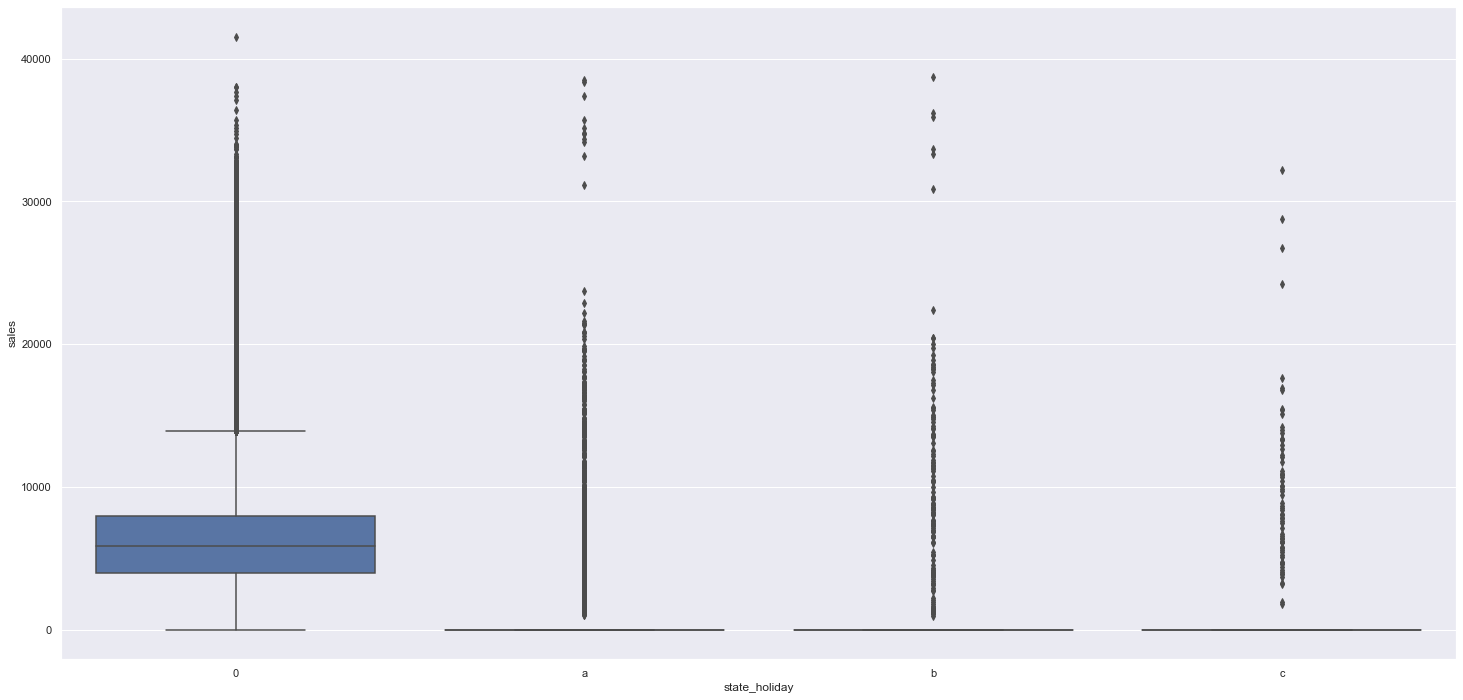

In [116]:
sns.boxplot( x='state_holiday', y='sales', data=df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

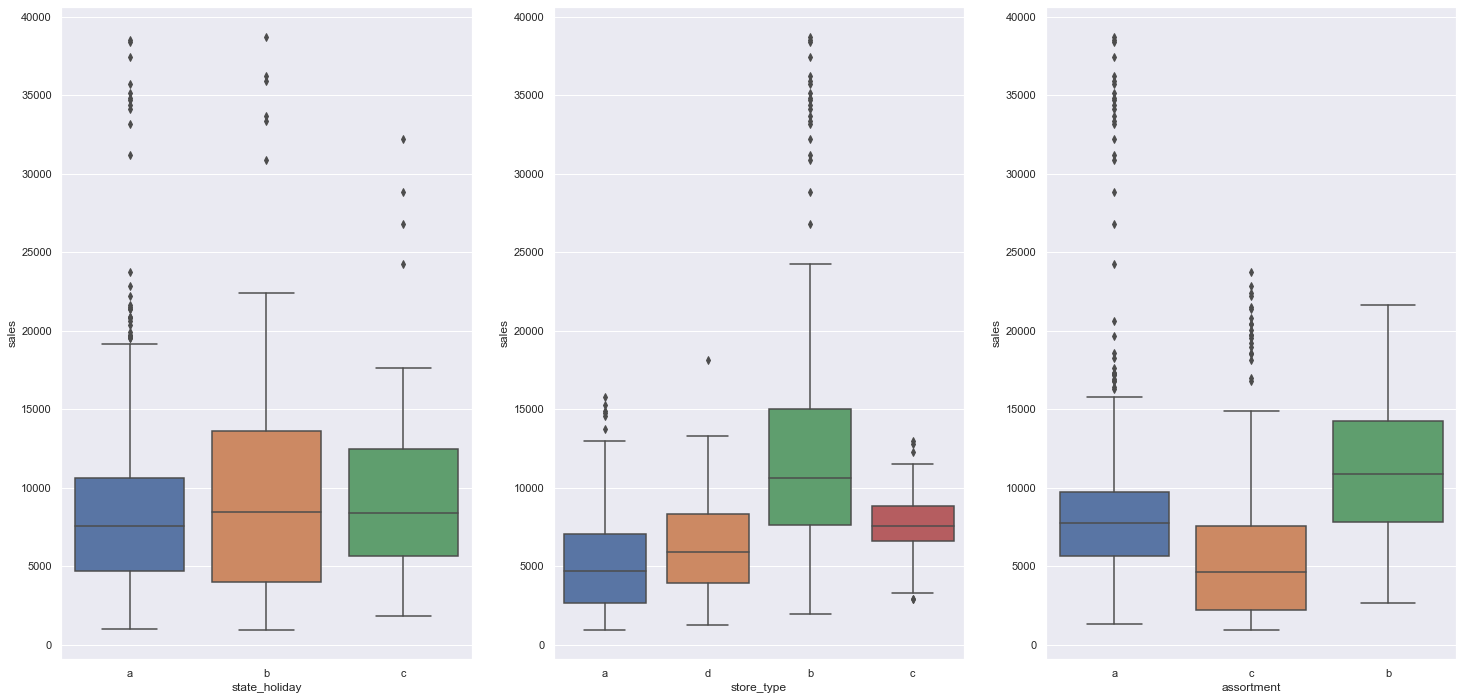

In [117]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)


**Linha do meio do retângulo:** Mediana (quartil 50)

**Linha de baixo do retângulo:** volume dos dos numeros dos quartis do 25 a 50

**Linha de cima do retângulo:** volume dos dos numeros dos quartis do 50 a 75

**Intervalo de cima fora do retângulo:** volume dos dos numeros dos quartis do 75 a 100

**Linha mais alta:** valor máximo

**Pontos fora:** outliers (3x o desvio padrão)


# Feature Engineering

## Lista final de hipóteses

1. Lojas com maior sortimentos deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vendem mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais dias de promoção deveriam vender mais.

7. Lojas com mais promoções consecutivas deveriam vender mais.

8. Lojas abertas durante o feriado de Natal deveriam vender mais.

9. Lojas deveriam vender mais ao longo dos anos.

10. Lojas deveriam vender mais no segundo semestre do ano.

11. Lojas deveriam vender mais depois do dia 10 de cada mês.

12. Lojas deveriam vender menos aos finais de semana.

13. Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [118]:
df2 = df1.copy()

In [119]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


#competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'] , day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype( np.int64 )

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since']) /7).apply(lambda x: x.days).astype(np.int64)


#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x=='c' else 'regular_day')

<ipython-input-119-2abeb55f5ca7>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [120]:
df2.head().T

0                    1                    2                    3                    4
store                                           1                    2                    3                    4                    5
day_of_week                                     5                    5                    5                    5                    5
date                          2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                        5263                 6064                 8314                13995                 4822
customers                                     555                  625                  821                 1498                  559
open                                            1                    1                    1                    1                    1
promo                                           1                    1                    1                    1                    1
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  1                    1                    1                    1                    1
store_type                                      c                    a                    a                    c                    a
assortment                                  basic                basic                basic             extended                basic
competition_distance                         1270                  570                14130                  620                29910
competition_open_since_month                    9                   11                   12                    9                    4
competition_open_since_year                  2008                 2007                 2006                 2009                 2015
promo2                                          0                    1                    1                    0                    0
promo2_since_week                              31                   13                   14                   31                   31
promo2_since_year                            2015                 2010                 2011                 2015                 2015
promo_interval                                  0      Jan,Apr,Jul,Oct      Jan,Apr,Jul,Oct                    0                    0
month_map                                     Jul                  Jul                  Jul                  Jul                  Jul
is_promo                                        0                    1                    1                    0                    0
year                                         2015                 2015                 2015                 2015                 2015
month                                           7                    7                    7                    7                    7
day                                            31                   31                   31                   31                   31
week_of_year                                   31                   31                   31                   31                   31
year_week                                 2015-30              2015-30              2015-30              2015-30              2015-30
competition_since             2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         84                   94                  105                   71                    4
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                 0                  279                  226                    0                    0

# Filtragem de variáveis

In [121]:
df3 = df2.copy()

## Filtragem das linhas

In [122]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Selecao das Colunas

In [123]:
cols_drop = ['customers', 'open','promo_interval','month_map']

In [124]:
df3 = df3.drop(cols_drop, axis=1)

# Analíse Exploratória dos Dados

In [125]:
df4 = df3.copy()

## Analíse Univariada

### Response Variable

C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


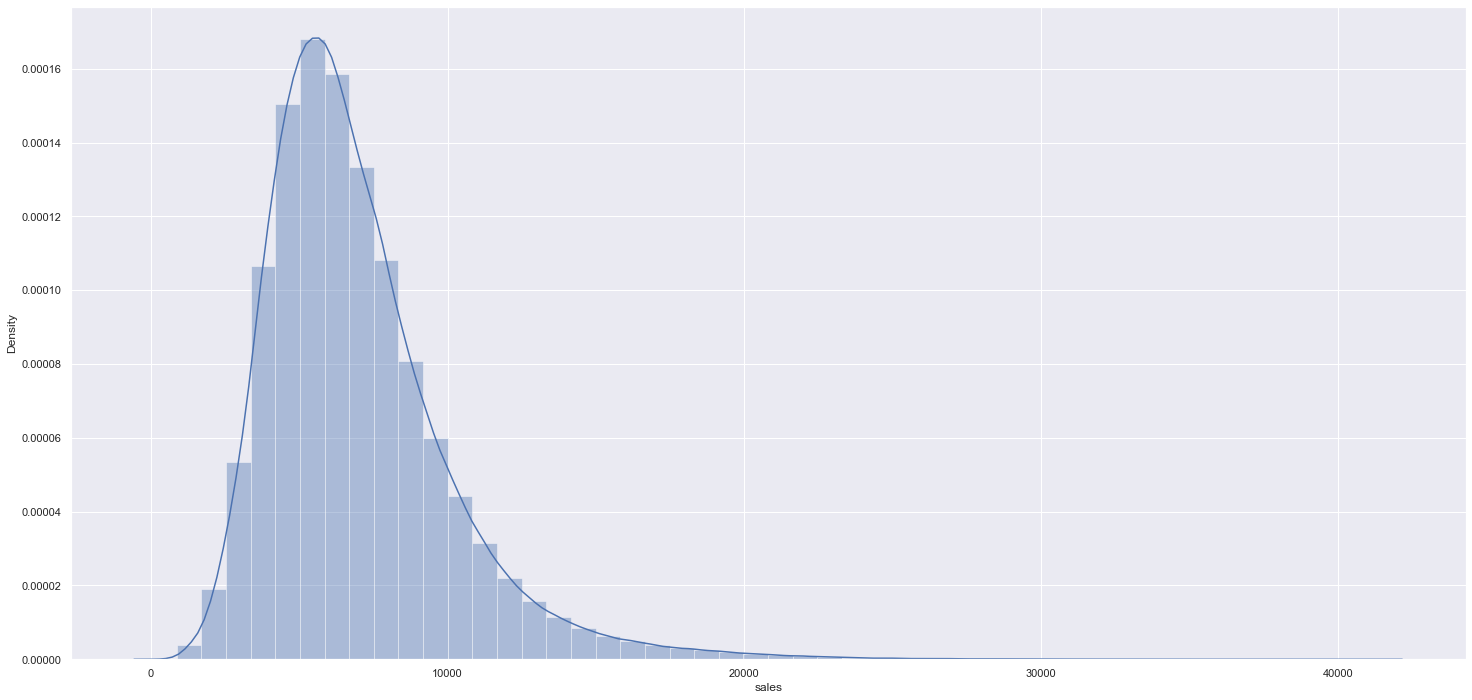

In [126]:
sns.distplot(df4['sales']);

Os dados sejam independentes e os gráficos sejam normalmente distribuídos para um algoritmo de ML rodar melhor.

### Numerical Variable

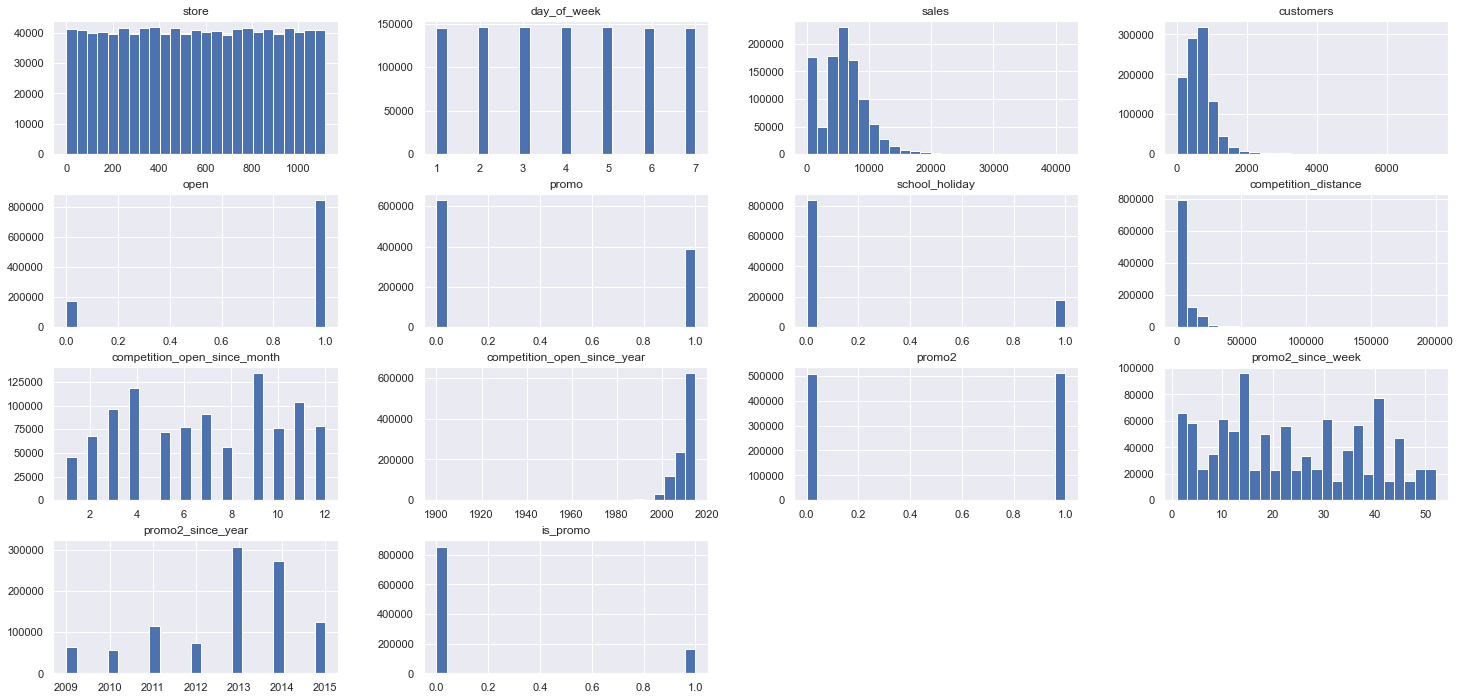

In [127]:
num_attributes.hist(bins=25);

### Categorical Variable

C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

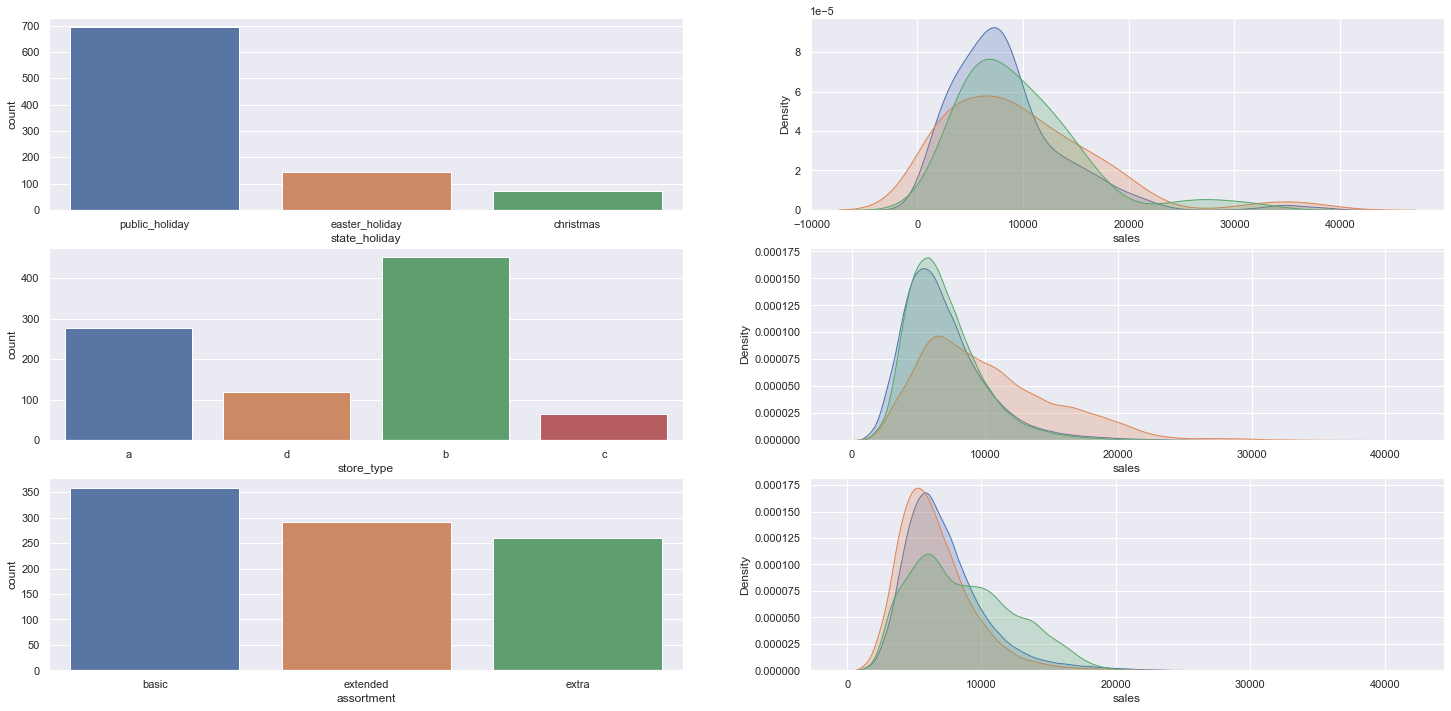

In [128]:
#state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='christmas_holiday',
            shade=True)

#store_type

plt.subplot(3, 2, 3)
sns.countplot(a['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)

#assortment

plt.subplot(3, 2, 5)
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra',
            shade=True)

## Analíse Bivariada

### Lojas com maior sortimentos deveriam vender mais.

Hipótese Falsa

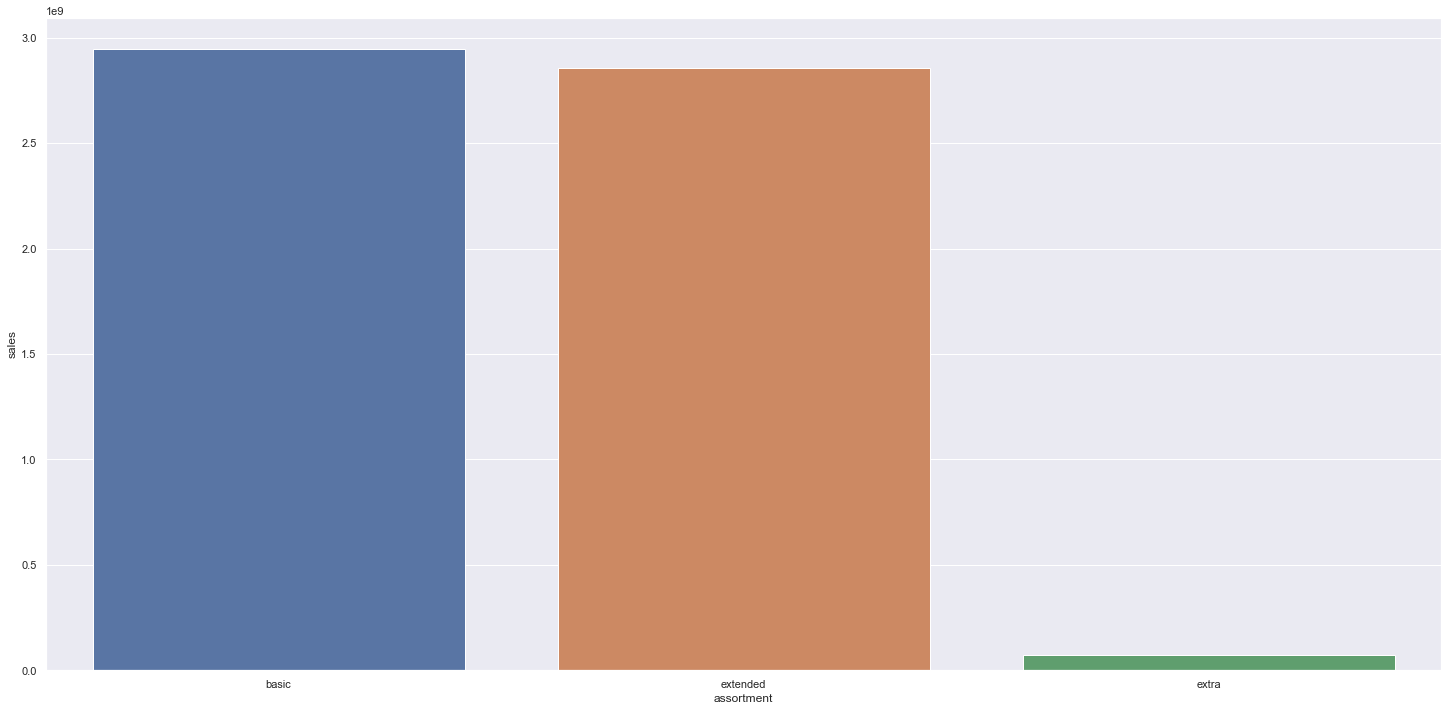

In [129]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

<AxesSubplot:xlabel='year_week'>

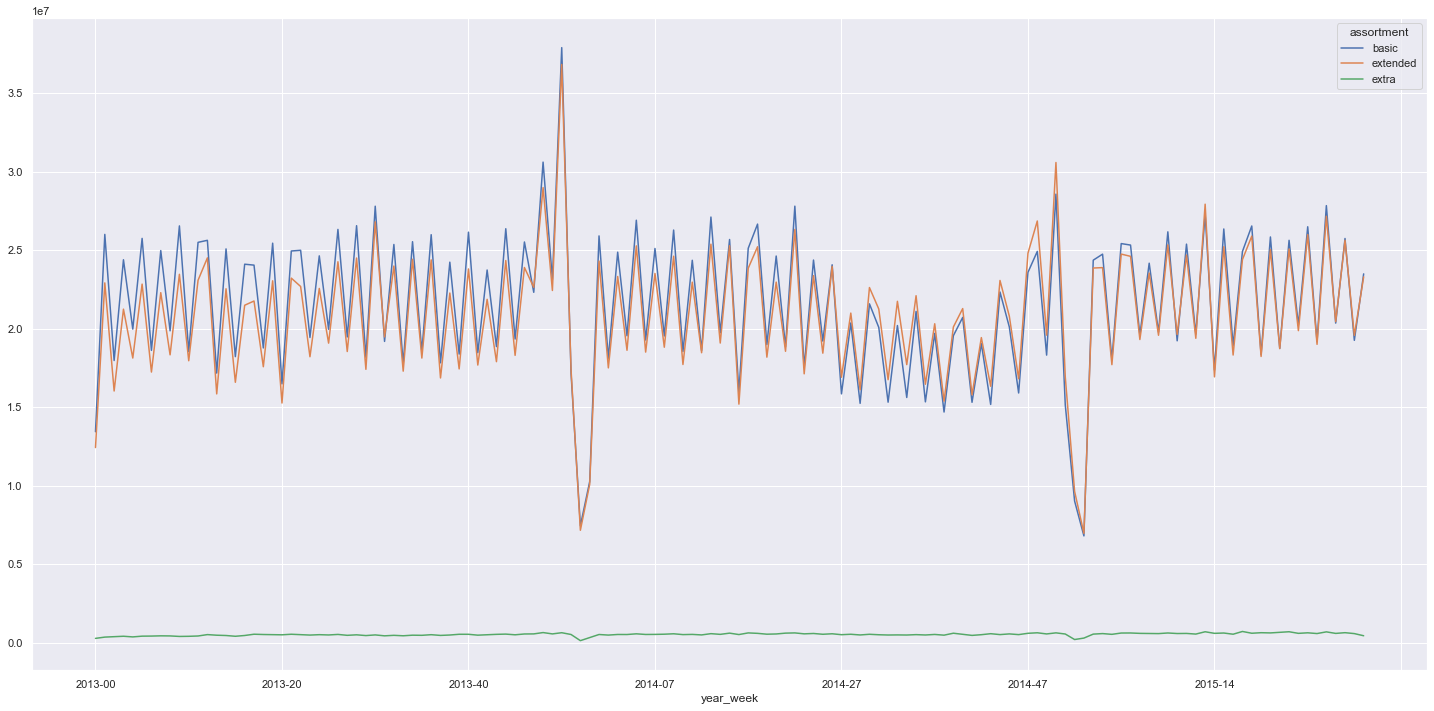

In [130]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

<AxesSubplot:xlabel='year_week'>

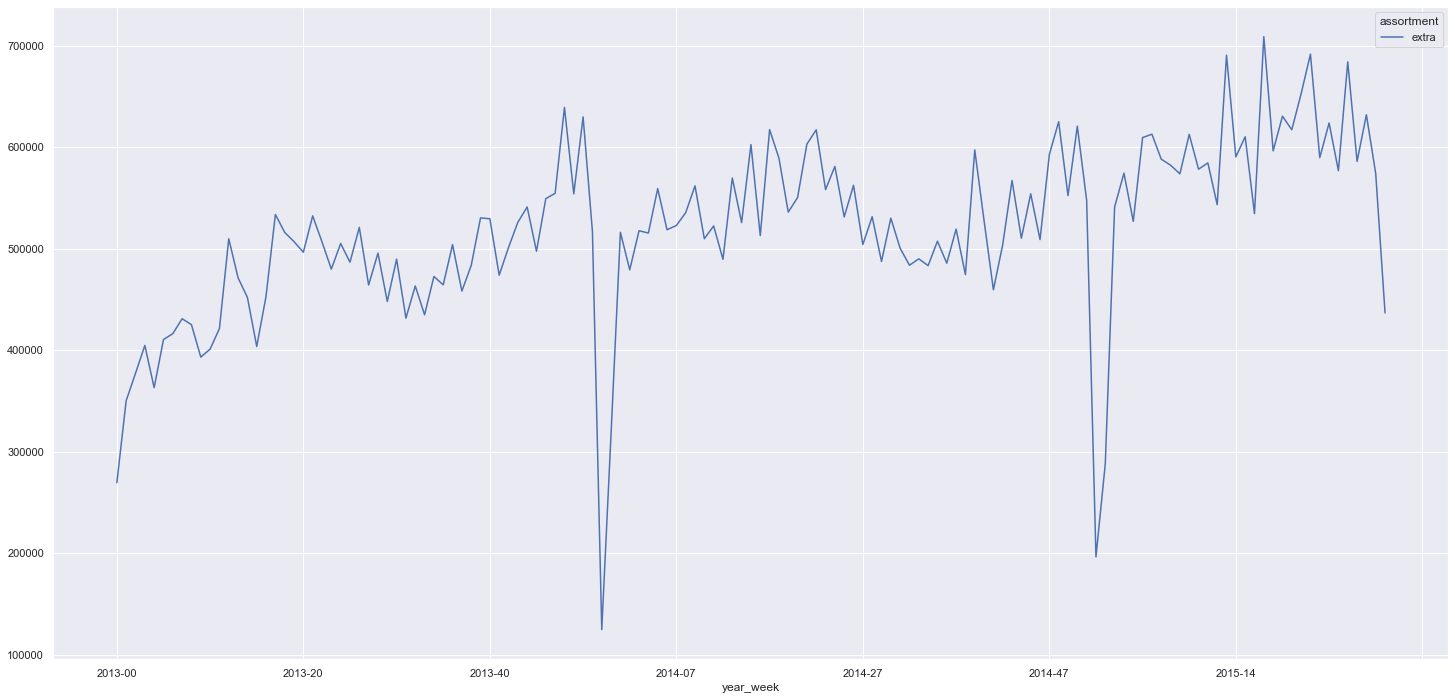

In [131]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### Lojas com competidores mais próximos deveriam vender menos.

    Hipótese False: lojas com competidores mais próximos vendem mais

In [132]:
bins = list(np.arange(0, 20000, 1000))

In [133]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

In [134]:
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

In [135]:
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

<AxesSubplot:>

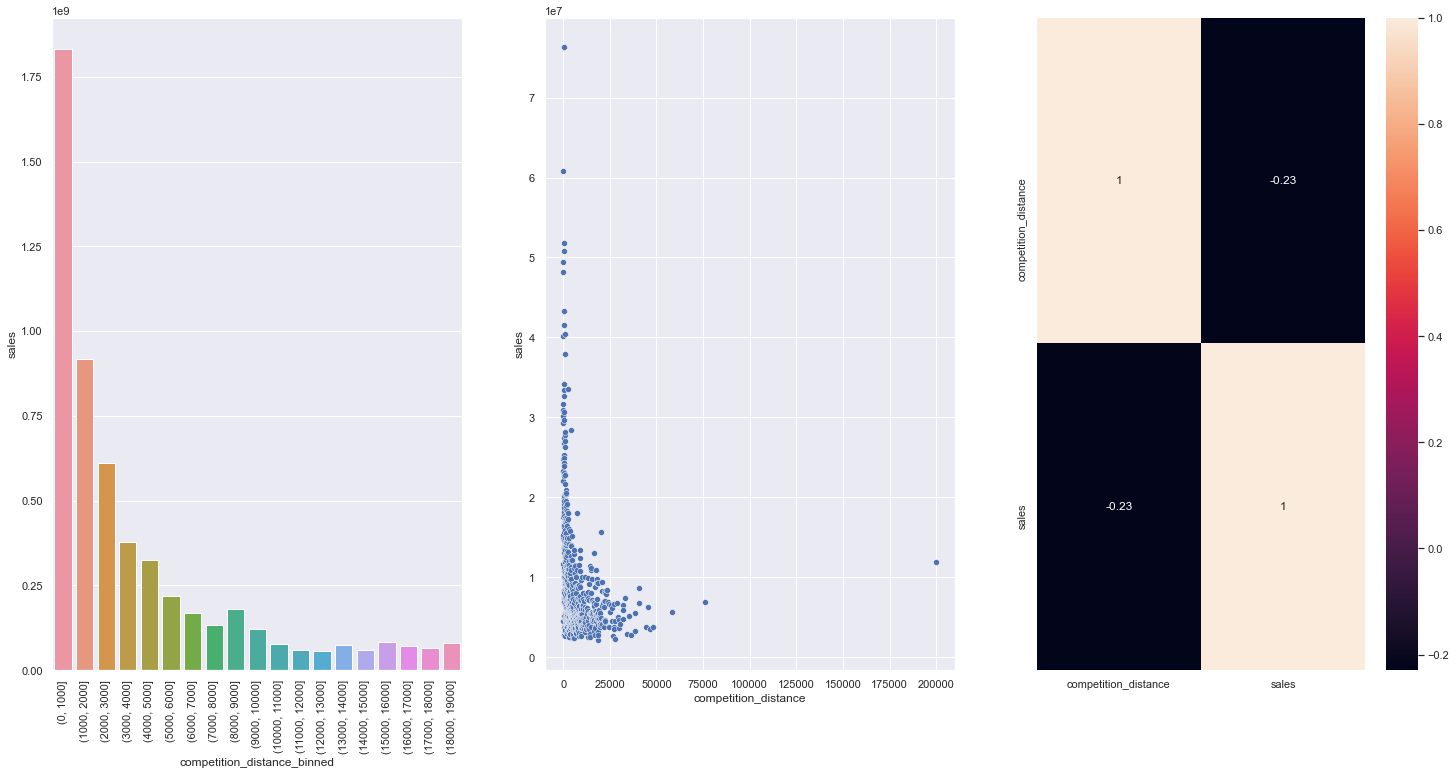

In [136]:
plt.subplot(1,3,1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90) # rotacionar os label do x
plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

**Heatmap:** Quanto mais próxima de 0, mais fraca a correlação, quanto mais próximo de 1 ou -1, mais forte a correlação
    
    Negativa = quanto mais distante meu concorrente está, menor a venda

### Lojas com competidores à mais tempo deveriam vendem mais.
Hipótese False: lojas com competidores a mais tempo vendem menos

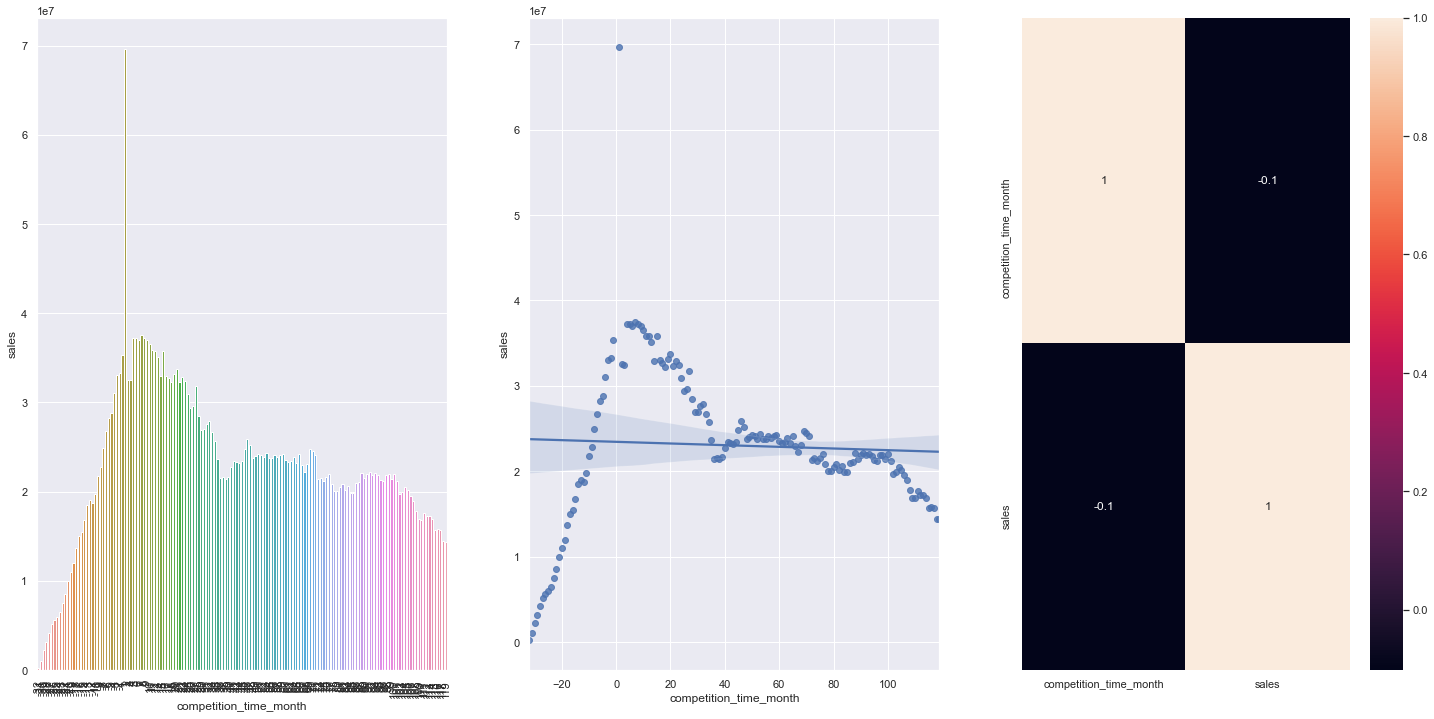

In [137]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & ( aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

### Lojas com promoções ativas por mais tempo deveriam vender mais.
Hipótese False: depois de um tempo a quantidade de vendas diminuem

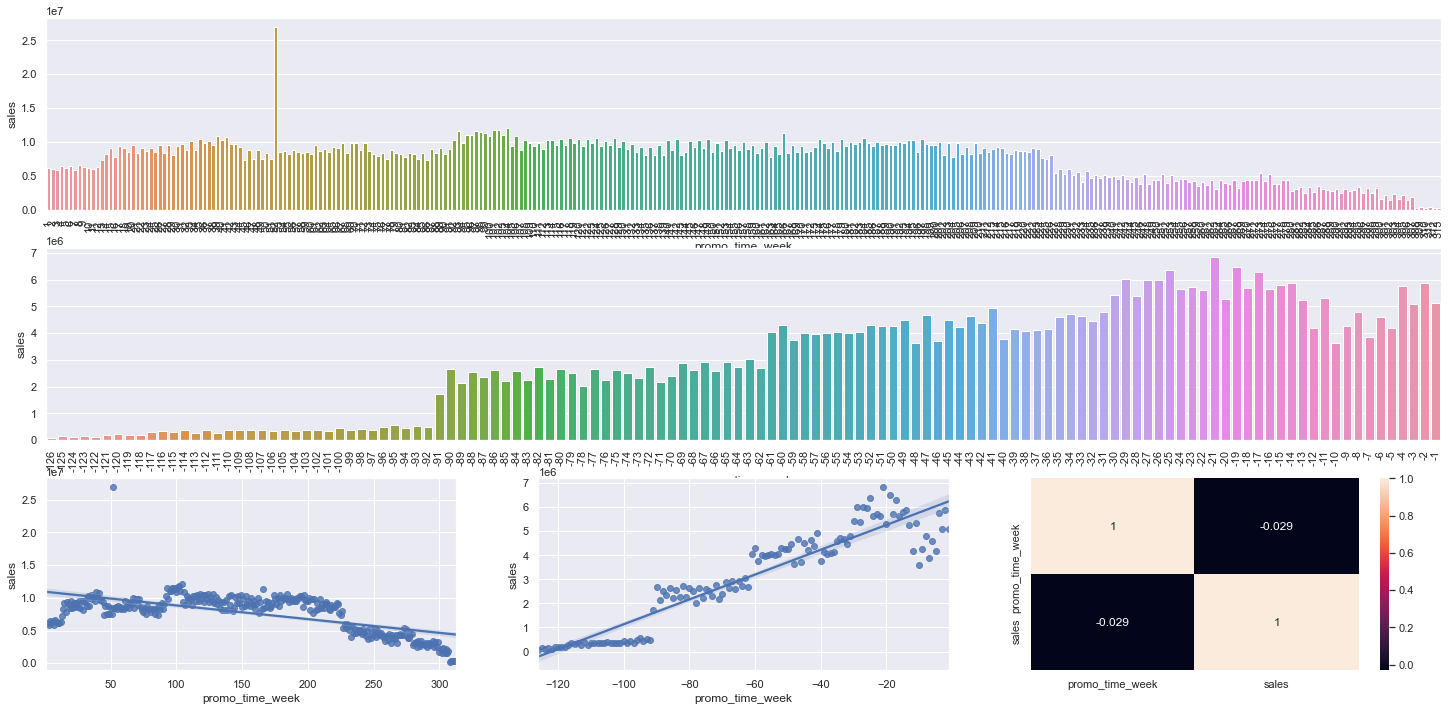

In [138]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot( x='promo_time_week', y='sales', data=aux1)

grid = GridSpec( 3, 3)

plt.subplot(grid[0,:])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90 );


plt.subplot(grid[2,0])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,:])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

plt.subplot(grid[2,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[2,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### <s>Lojas com mais dias de promoção deveriam vender mais.</s>

### Lojas com mais promoções consecutivas deveriam vender mais.
Hipótese False: lojas com mais promoções consecutivas vendem menos

In [139]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

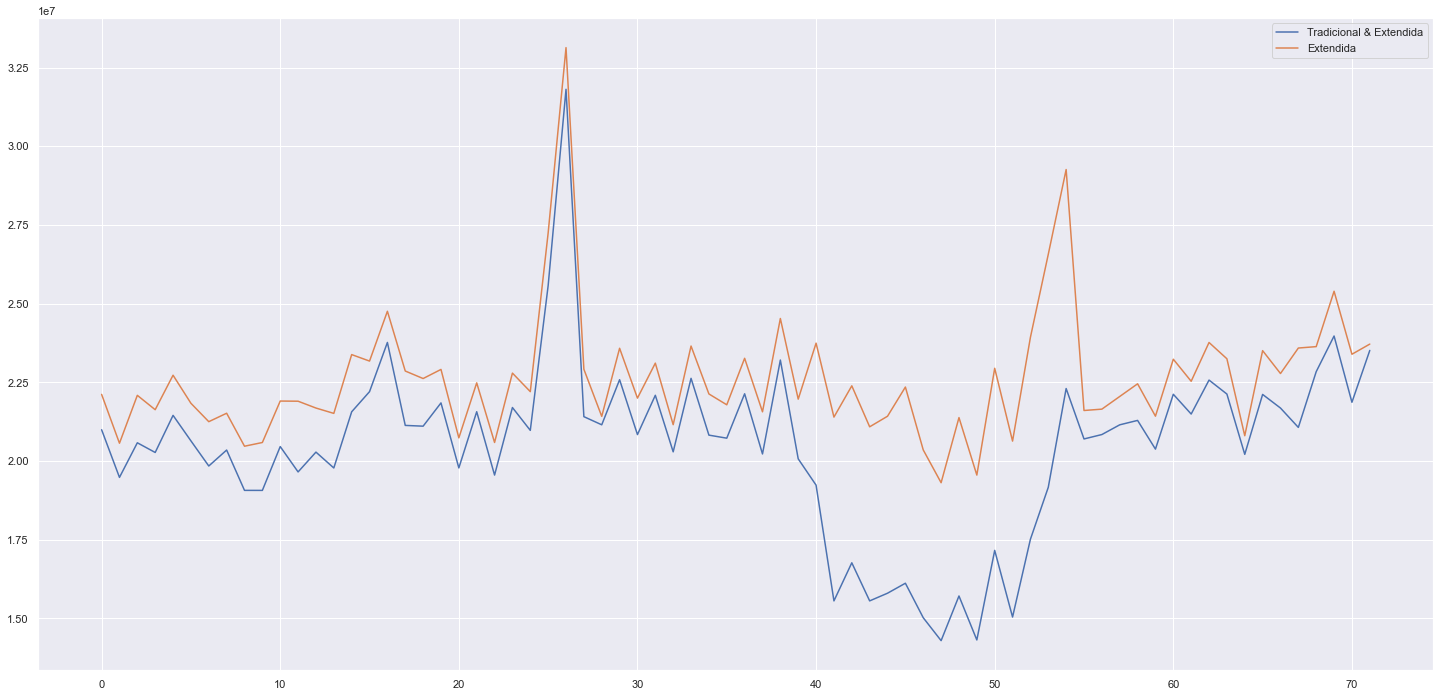

In [140]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
aux2.plot( ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

### Lojas abertas durante o feriado de Natal deveriam vender mais.
Hipotese False: lojas abertas durante o natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

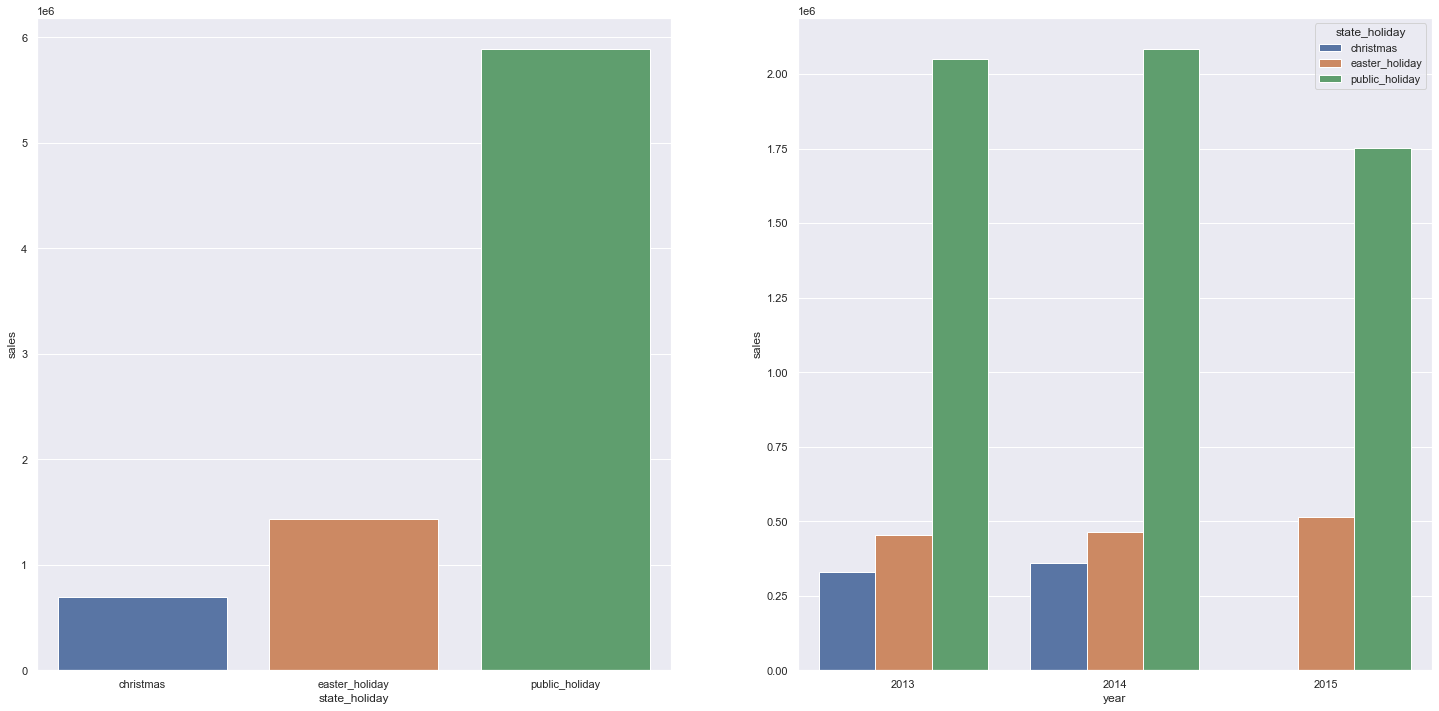

In [141]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### Lojas deveriam vender mais ao longo dos anos.
Hipótese False: lojas vendem menos ao longo dos anos

<AxesSubplot:>

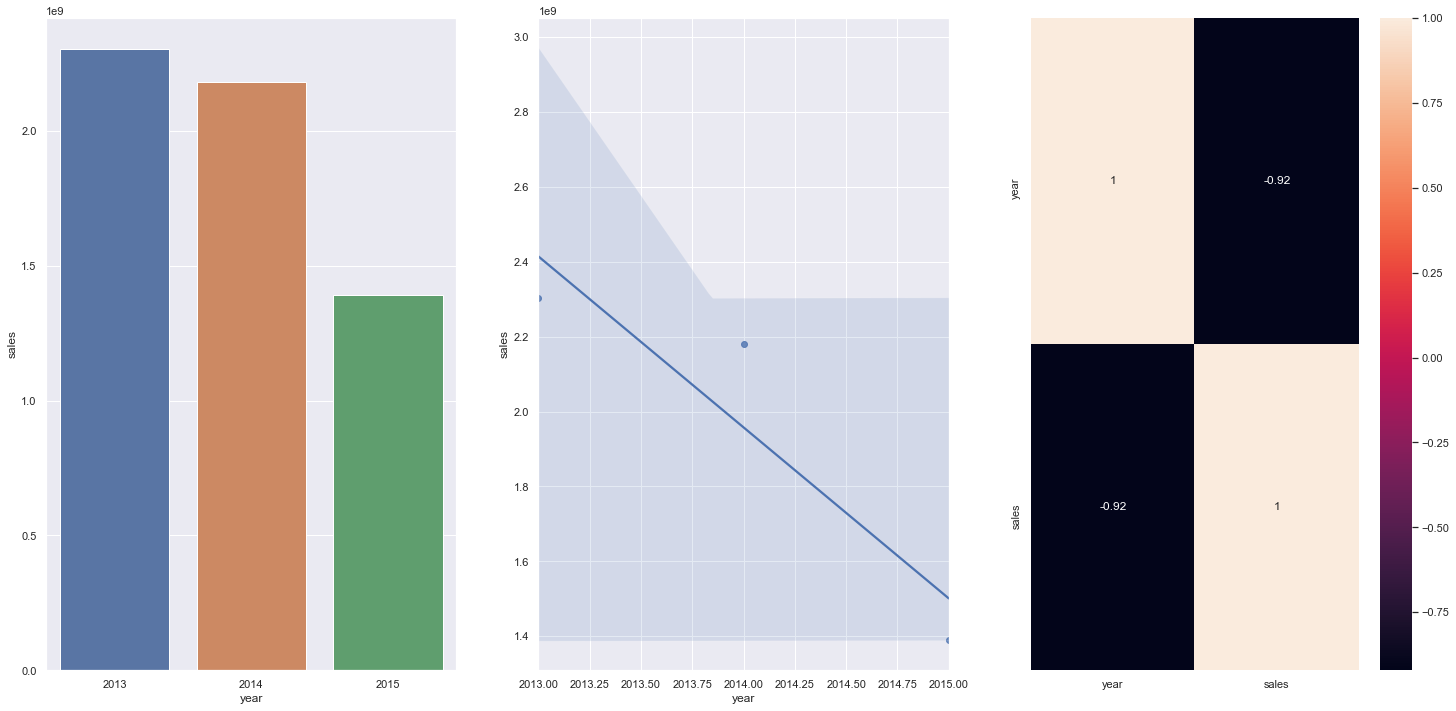

In [142]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

### Lojas deveriam vender mais no segundo semestre do ano.
Hipótese False: as lojas vendem menos no segundo semestre

<AxesSubplot:>

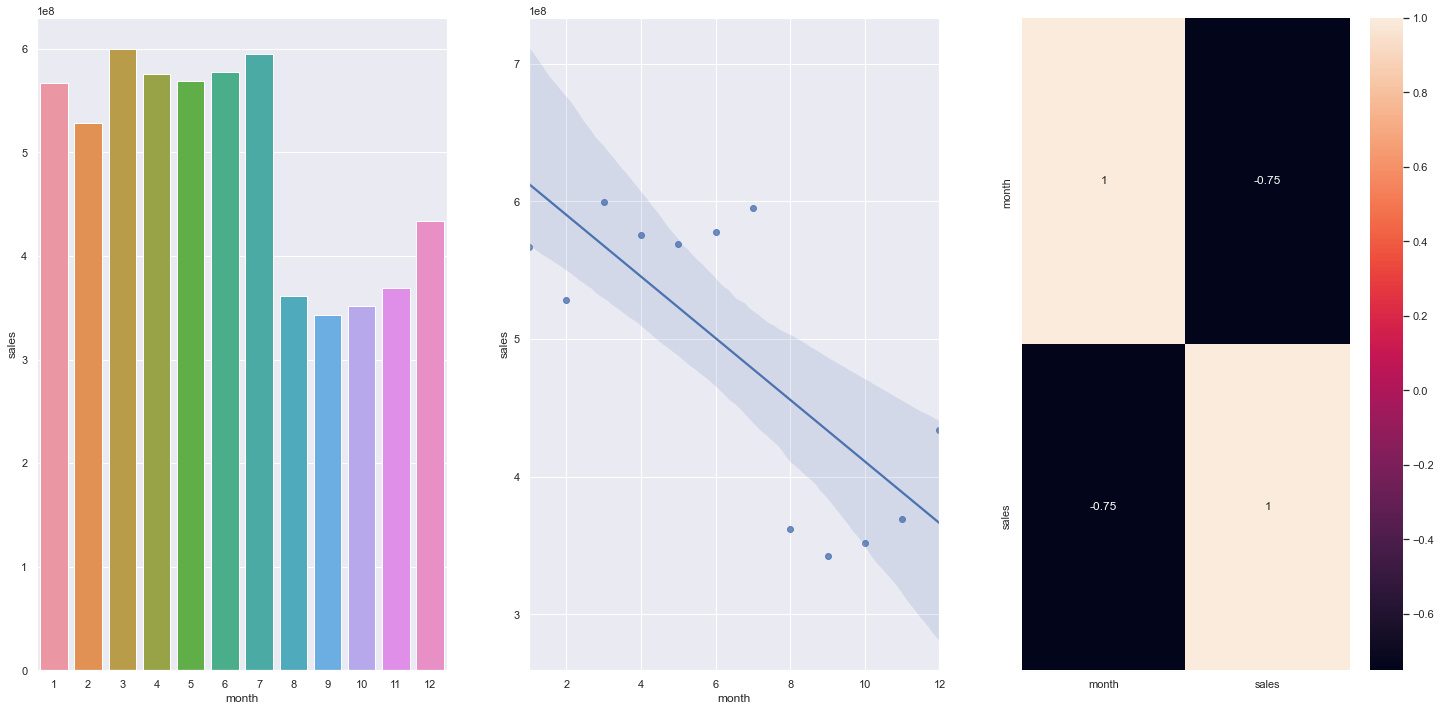

In [143]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

### Lojas deveriam vender mais depois do dia 10 de cada mês.
Hipótese Verdadeira: tem mais vendas depois do dia 10

<AxesSubplot:xlabel='before_after', ylabel='sales'>

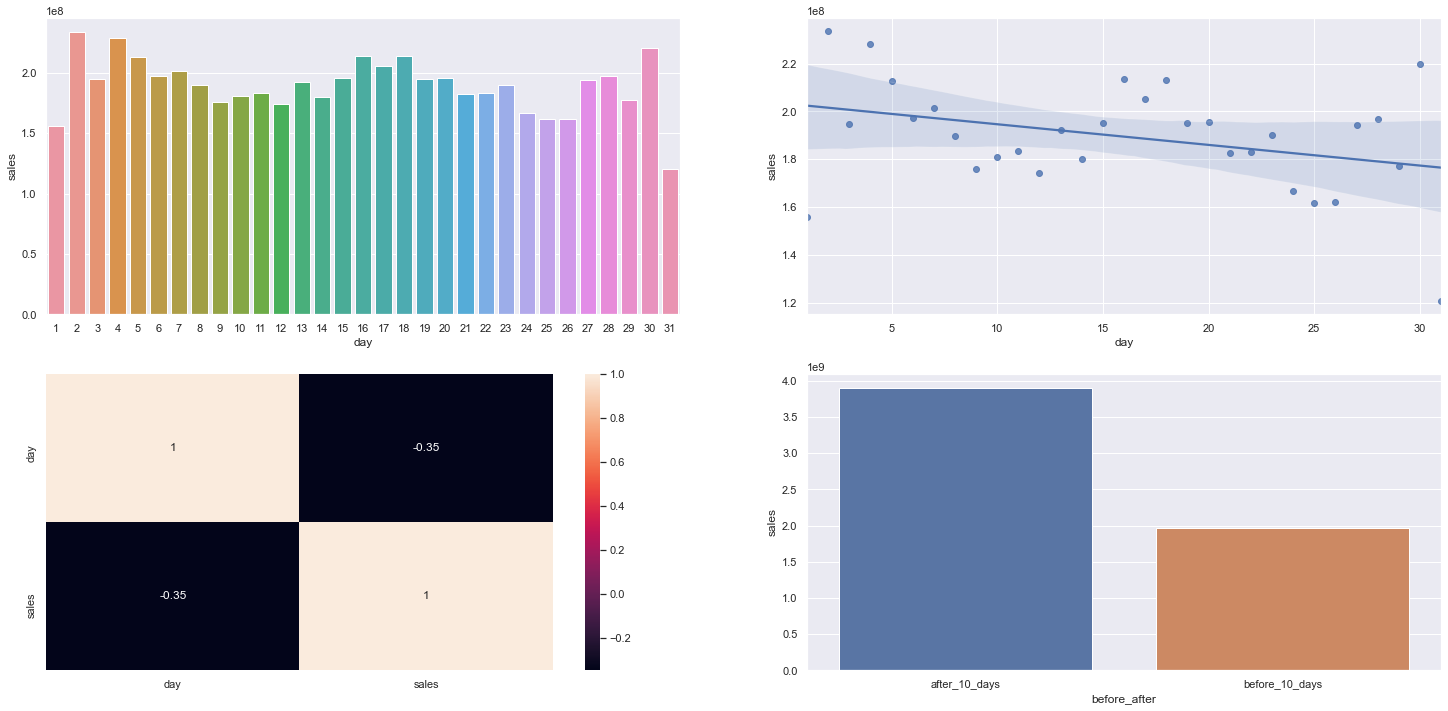

In [144]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

### Lojas deveriam vender menos aos finais de semana.
Hipótese False: as lojas vendem menos nos finais de semana

<AxesSubplot:>

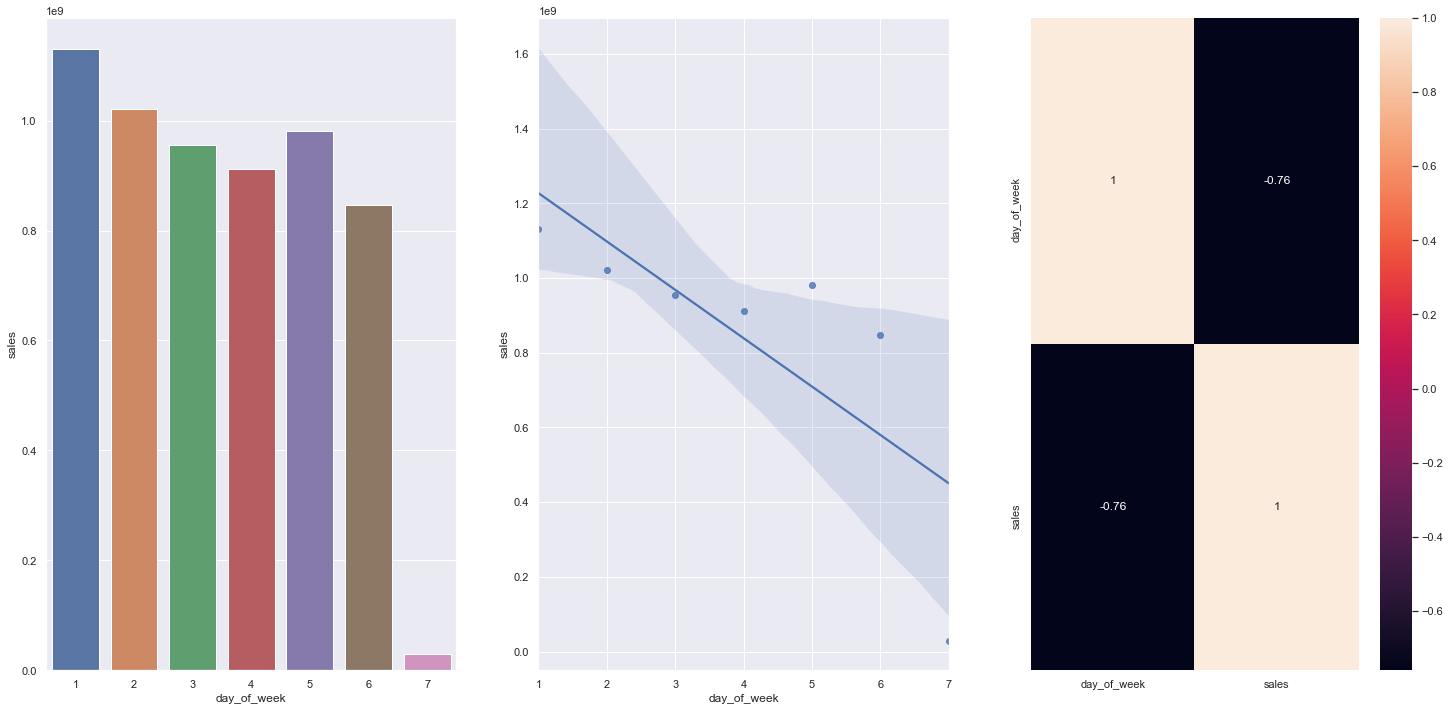

In [145]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True)

### Lojas deveriam vender menos durante os feriados escolares.
Hipótese verdadeira: lojas vendem menos durante feriados escolares, menos nos meses julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

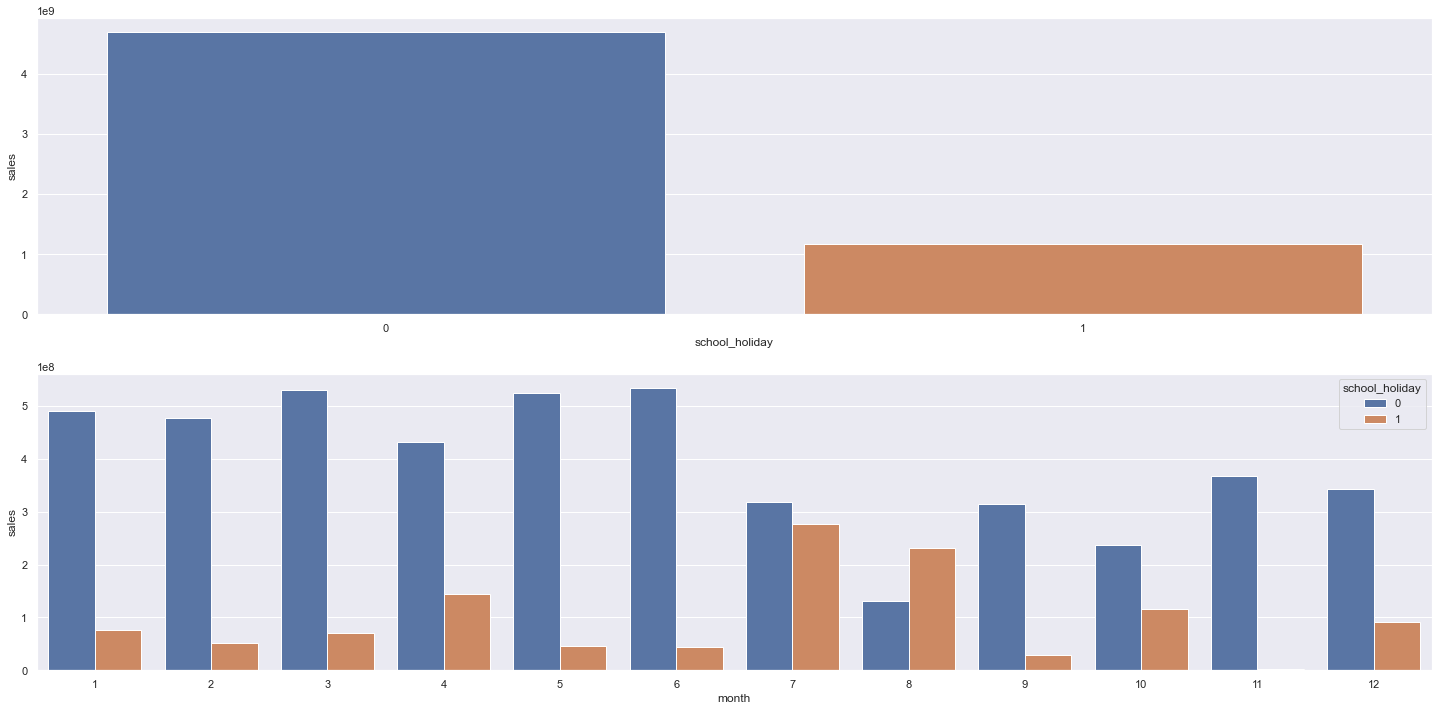

In [146]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## Análise multivariada

### Numerical Attributes

<AxesSubplot:>

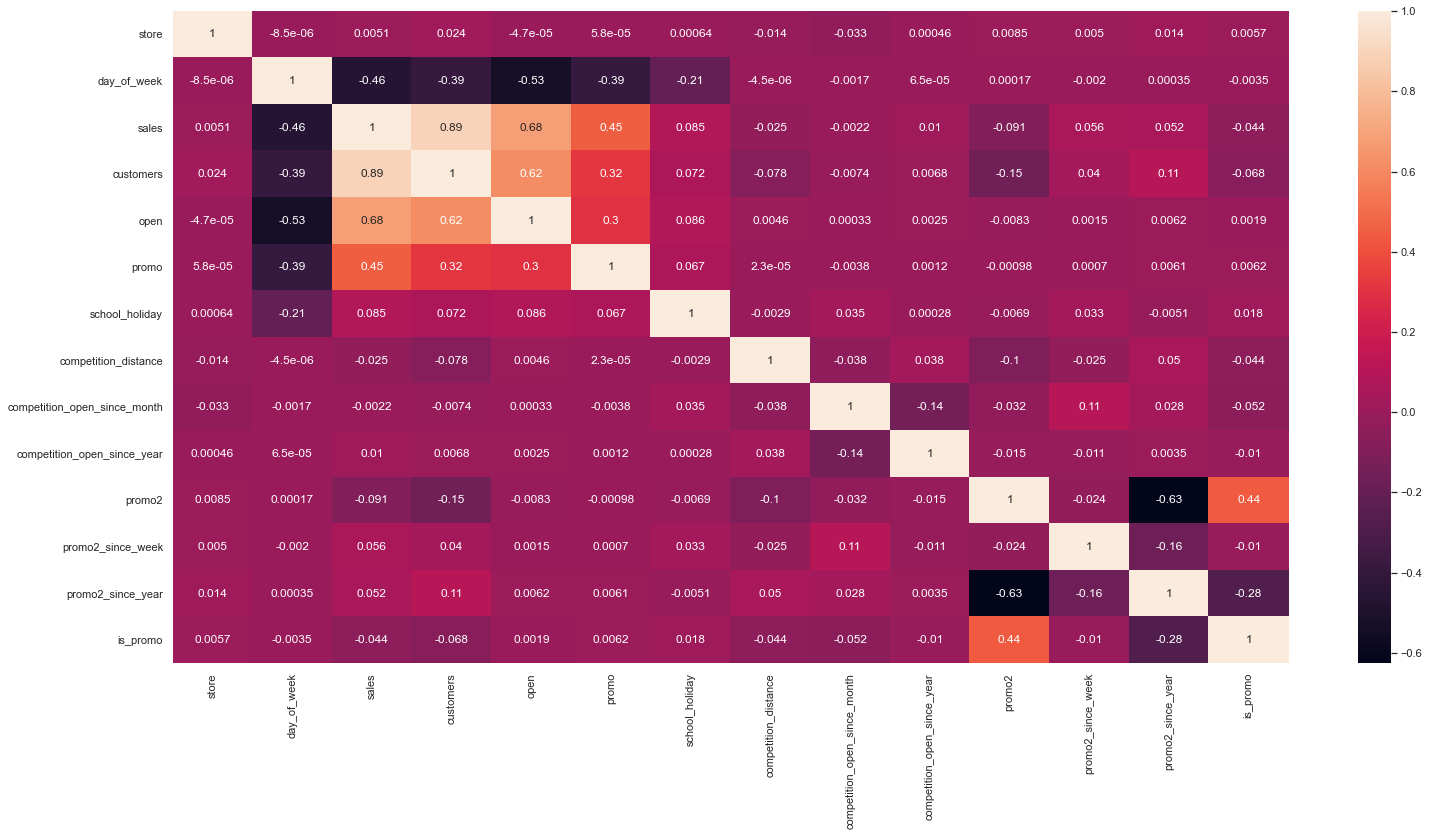

In [147]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### <s>Categorical Attributes</s>

In [148]:
a = df4.select_dtypes(include='object')

In [149]:
from scipy import stats as ss

In [150]:
def cramer_v( x, y ):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / min( kcorr-1, rcorr - 1))
    

# Data Preparation

In [151]:
df5 = df4.copy()

## Normalização

## Rescaling

In [152]:
a = df5.select_dtypes( include = ['int64', float64] )

In [153]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform( df5[['year']].values)

C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

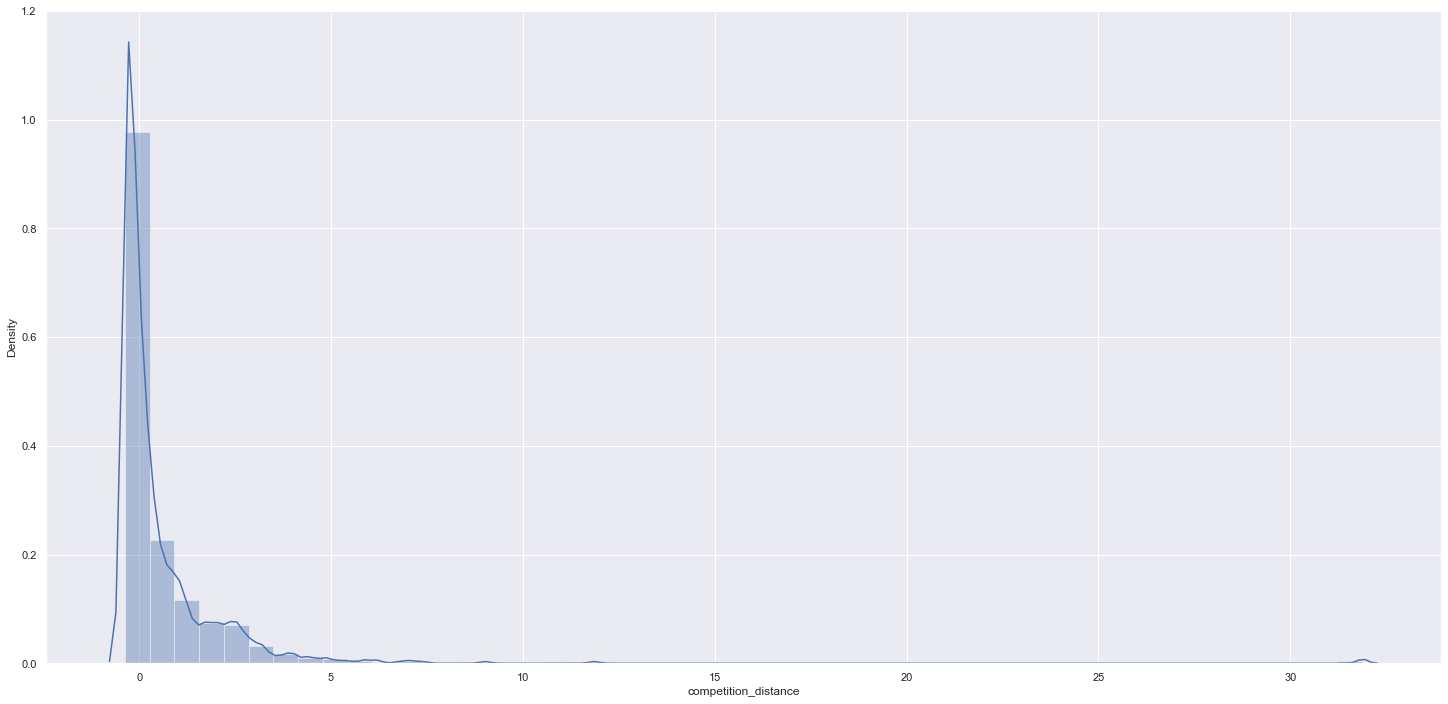

In [154]:
sns.distplot(df5['competition_distance'])

## Transformação

### Encoding

In [155]:
#state_holiday - One hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le= LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic':1,
                  'extra':2,
                  'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)



### Natural Transformation

In [156]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

#day
df5['day_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

#day of week
df5['day_of_week_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

In [157]:
df5.head()

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day  month_sin  month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos  day_of_week_sin  day_of_week_cos
0      1            5 2015-07-31   5263      1               1           2           1             -0.170968                             9                         2008       0                 31               2015         0   1.0      7   31            31   2015-30        2008-09-01                0.918919  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.994522  0.104528          0.748511          0.663123    -2.449294e-16              1.0
1      2            5 2015-07-31   6064      1               1           0           1             -0.283871                            11                         2007       1                 13               2010         1   1.0      7   31            31   2015-30        2007-11-01                1.054054  2010-03-22         0.922551                        0                             0                             0                          1       -0.5  -0.866025  0.994522  0.104528          0.748511          0.663123    -2.449294e-16              1.0
2      3            5 2015-07-31   8314      1               1           0           1              1.903226                            12                         2006       1                 14               2011         1   1.0      7   31            31   2015-30        2006-12-01                1.202703  2011-03-28         0.801822                        0                             0                             0                          1       -0.5  -0.866025  0.994522  0.104528          0.748511          0.663123    -2.449294e-16              1.0
3      4            5 2015-07-31  13995      1               1           2           3             -0.275806                             9                         2009       0                 31               2015         0   1.0      7   31            31   2015-30        2009-09-01                0.743243  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.994522  0.104528          0.748511          0.663123    -2.449294e-16              1.0
4      5            5 2015-07-31   4822      1               1           0           1              4.448387                             4                         2015       0                 31               2015         0   1.0      7   31            31   2015-30        2015-04-01               -0.162162  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.994522  0.104528          0.748511          0.663123    -2.449294e-16              1.0

In [158]:
df5['sales'] = np.log1p( df5['sales'] )

# Feature Selection

In [159]:
df6 = df5.copy()

## Split dataframe into training and test dataset

In [160]:
cols_drop = ['day_of_week', 'week_of_year', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [161]:
#ultimas 6 semenas separa como teste 31-07-2015
#antes dessas 6 semanas será treino 02-01-2013

df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7) 
#a partir dessa data serão os dados de teste e antes dela serão os dados de treino

Timestamp('2015-06-19 00:00:00')

In [162]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format (X_train['date'].min()))
print('Training max date: {}'.format (X_train['date'].max()))

print('\nTest min date: {}'.format (X_test['date'].min()))
print('Test max date: {}'.format (X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [163]:
##training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()
#
##define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)
#
##define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n)

### Best Features from Boruta

In [164]:
#cols_selected = boruta.support_.tolist()
#
##best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
##not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [165]:
#cols_selected_boruta

In [166]:
#cols_not_selected_boruta

In [167]:
#comparar as variáveis que o boruta escolheu, com as variáveis escolhidas fazendo a análise exploratória

In [168]:
cols_selected_boruta_of = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week']

In [169]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 
                        'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

#add columns
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [170]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Machine Learning Modelling

In [171]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
x_training = X_train[cols_selected_boruta_full]

## Average Model 
Modelo de Média

In [172]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']


baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model Name          MAE      MAPE         RMSE
0  Average Model  1354.800353  0.455051  1835.135542

## Linear Regression Model

In [173]:
#model
lr = LinearRegression().fit( x_train, y_train)

#prediction
yhat_lr = lr.predict( x_test )

#perfomance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1898.522193  0.296771  2716.620535

### LR - Cross Validation

In [174]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

Model Name              MAE CV       MAPE CV             RMSE CV
0  Linear Regression  2063.67 +/- 252.54  0.3 +/- 0.02  2925.15 +/- 344.89

## Linear Regression Regularized Model

In [175]:
#model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train)

#prediction
yhat_lrr = lrr.predict( x_test )

#perfomance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1907.791375  0.293827  2756.968319

### Lasso - Cross Validation

In [176]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

Model Name              MAE CV        MAPE CV             RMSE CV
0  Linear Regression - Lasso  2115.42 +/- 321.07  0.29 +/- 0.01  3056.23 +/- 470.75

## Random Forest Regressor

In [177]:
#model

rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

#prediction
yhat_rf = rf.predict( x_test )

#perfomance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name        MAE      MAPE         RMSE
0  Random Forest Regressor  902.08721  0.137915  1286.463258

### Random Forest Regressor - Cross Validation

In [178]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


Model Name              MAE CV        MAPE CV             RMSE CV
0  Random Forest Regressor  1180.46 +/- 249.01  0.17 +/- 0.02  1660.31 +/- 370.87

## XGBoost Regressor

In [179]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10, subsample=0.7, colsample_bytee=0.9).fit( x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict( x_test )

#perfomance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[18:05:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  6684.747225  0.949771  7330.377212

### XGBoost Regressor - Cross Validation

In [180]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

KFold Number: 5
[18:07:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4
[18:09:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3
[18:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2
[18:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1
[18:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Model Name              MAE CV       MAPE CV             RMSE CV
0  XGBoost Regressor  7048.89 +/- 588.16  0.95 +/- 0.0  7714.16 +/- 690.25

## Compare Model's Performance

### Single Performance

In [181]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   902.087210  0.137915  1286.463258
0              Average Model  1354.800353  0.455051  1835.135542
0          Linear Regression  1898.522193  0.296771  2716.620535
0  Linear Regression - Lasso  1907.791375  0.293827  2756.968319
0          XGBoost Regressor  6684.747225  0.949771  7330.377212

## Real Performance

In [182]:
modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values( 'RMSE CV' )

Model Name              MAE CV        MAPE CV             RMSE CV
0    Random Forest Regressor  1180.46 +/- 249.01  0.17 +/- 0.02  1660.31 +/- 370.87
0          Linear Regression  2063.67 +/- 252.54   0.3 +/- 0.02  2925.15 +/- 344.89
0  Linear Regression - Lasso  2115.42 +/- 321.07  0.29 +/- 0.01  3056.23 +/- 470.75
0          XGBoost Regressor  7048.89 +/- 588.16   0.95 +/- 0.0  7714.16 +/- 690.25

# Hyperparameter Fine Tuning

## Random Search

In [183]:
import random

In [184]:
param = {
    'n_estimators':[1500, 1700, 2500, 3000, 3500],
    'eta':[0.01, 0.03],
    'max_depth':[3, 5, 9],
    'subsample':[0.1, 0.5, 0.7],
    'colsample_bytree':[0.3, 0.7, 0.9],
    'min_child_weight':[3, 8, 15],
        }

In [185]:
final_result = pd.DataFrame()
MAX_EVAL = 10
for i in range ( MAX_EVAL):
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )

    #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'], 
                                 colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])

    #perfomance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat( [final_result, result])

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
KFold Number: 5


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 4


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 3


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 2


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KFold Number: 1


C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [186]:
final_result

Model Name              MAE CV        MAPE CV             RMSE CV
0  XGBoost Regressor  1578.02 +/- 194.47  0.22 +/- 0.01   2272.06 +/- 267.4
0  XGBoost Regressor  1457.81 +/- 188.46   0.2 +/- 0.01  2090.31 +/- 265.03
0  XGBoost Regressor  1680.91 +/- 202.62  0.23 +/- 0.01  2418.86 +/- 279.44
0  XGBoost Regressor   1103.26 +/- 182.3  0.16 +/- 0.01  1557.84 +/- 293.42
0  XGBoost Regressor  1587.65 +/- 189.65  0.22 +/- 0.01  2279.19 +/- 264.11
0  XGBoost Regressor  1154.67 +/- 193.89  0.16 +/- 0.02  1642.86 +/- 301.06
0  XGBoost Regressor  1122.11 +/- 167.23  0.16 +/- 0.01   1559.1 +/- 268.69
0  XGBoost Regressor  1100.47 +/- 185.83  0.16 +/- 0.01   1546.1 +/- 294.79
0  XGBoost Regressor  1156.97 +/- 172.85  0.16 +/- 0.01  1634.12 +/- 266.84
0  XGBoost Regressor  1189.54 +/- 191.14  0.17 +/- 0.01  1695.63 +/- 296.09

## Final Model

In [190]:
param = {
    'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8
        }

In [191]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=hp['n_estimators'], 
                                    eta=hp['eta'], 
                                    max_depth=hp['max_depth'], 
                                    subsample=hp['subsample'], 
                                    colsample_bytree=hp['colsample_bytree'],
                                    min_child_weight=hp['min_child_weight']).fit( x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#perfomance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

C:\Users\NA101776\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Model Name          MAE      MAPE       RMSE
0  XGBoost Regressor  1030.412093  0.155514  1469.4844

# Tradução e interpretação do erro

In [192]:
df9 = X_test[ cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


<ipython-input-192-214f9cd56015>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-192-214f9cd56015>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## Business Performance

In [196]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolut_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge ( df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

## Total Performance

In [202]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index':'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format)
df93

Scenario             Values
0     predictions  R$ 280,189,184.00
1  worst_scenario  R$ 279,037,757.85
2   best_scenario  R$ 281,340,617.59

## Machine Learning Performance

In [203]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-203-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-203-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NA101776\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

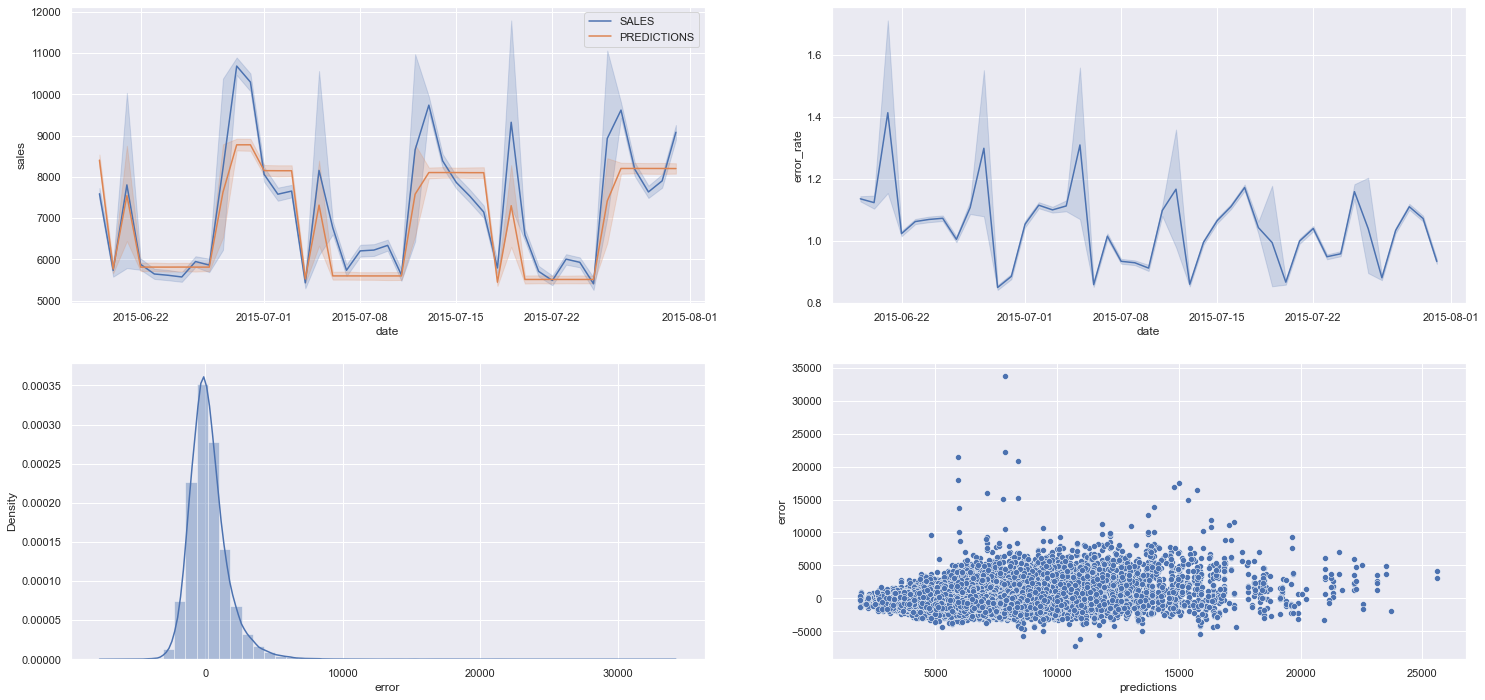

In [204]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.distplot( df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'])

In [206]:
import pickle

In [208]:
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))